# EEG to ECG Reconstruction


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale
from gpr_utils import train_pulse
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

from lib.utils import seed_everything
from lib.plot_utils import visualize_ecg_and_peaks, plot_augmentation_example, plot_train_hystory, visualize_predictions
from lib.dataset_utils import create_segments_sliding, create_training_segments_with_augmentation, create_segments_nonoverlapping, augment_segment
from lib.train_utils import evaluate_loader, subject_mae
from scipy.signal import butter, sosfiltfilt

seed_everything(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pytorch version: 2.7.1+cu126
CUDA version: 12.6
Tesla T4
Using device: cuda


In [12]:
# Configuration
A = 2              # Amplitude of the train pulses
width = 0.05       # Width of each pulse
tau = 5            # Lag (downsampling factor)
duration_sec = 10  # segment length

# Available subjects
subj_all = [29, 41, 30, 40, 23, 27, 28, 39]
test_subj = subj_all[0]
val_subj = subj_all[1]
train_subjects = [s for s in subj_all if s not in (test_subj, val_subj)]

# Pulse type for ECG transformation Gaussian or Rectangular
impulse = "Gaussian"

# Augmentation settings
use_augmentation = True
warp_factor_range = (0.85, 1.15)
aug_segment_duration = round(warp_factor_range[1] * duration_sec)       # seconds (larger than target to allow warping)
n_augmented_per_segment = 5

# Training settings
train_overlap = 0.9
batch_size = 16
learning_rate = 1e-3
epochs = 100
patience = 40

# Paths
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
parsed_path = os.path.join(cache_dir, "data_parsed.pkl")
preproc_path = os.path.join(cache_dir, "data_preprocessed.pkl")

# Heart-rate band filtering (~1 Hz)
use_hr_band_filter = True
lowcut=5
highcut=25

# Use only the first N seconds of each subject (after downsampling)
dataset_max_seconds = 120

## Load, Parse and Preprocess

Loaded parsed and preprocess data from cache


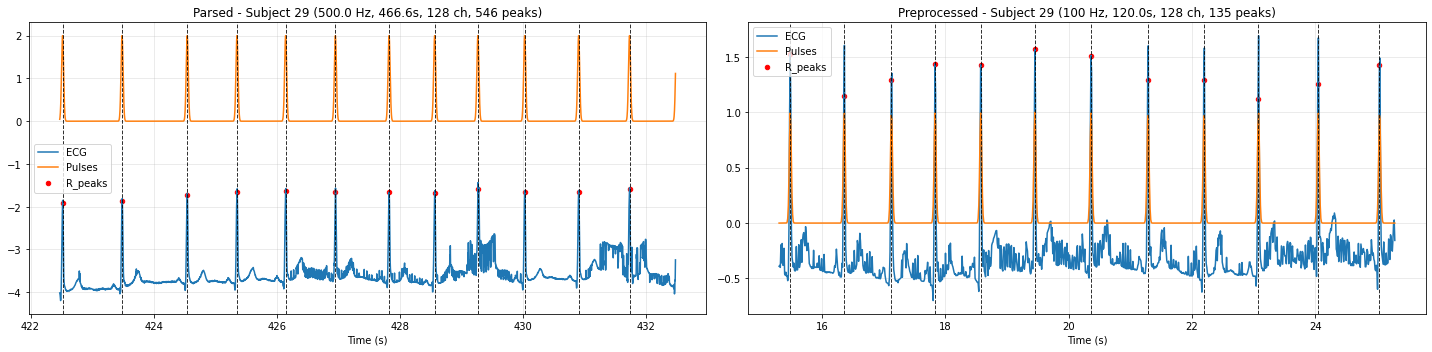

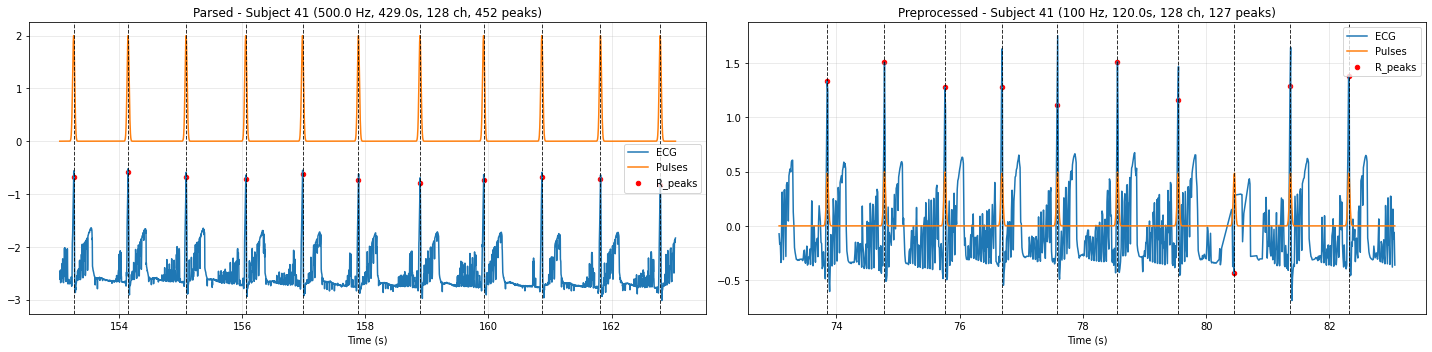

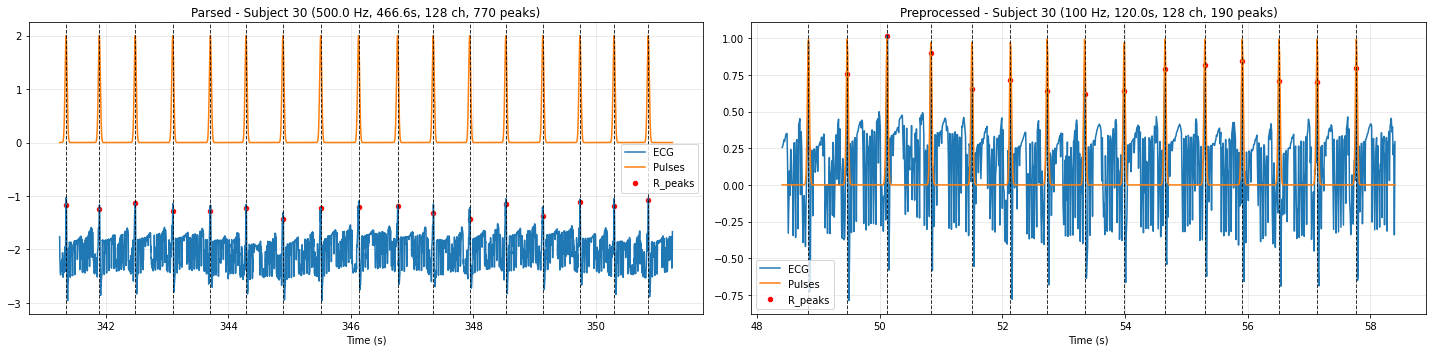

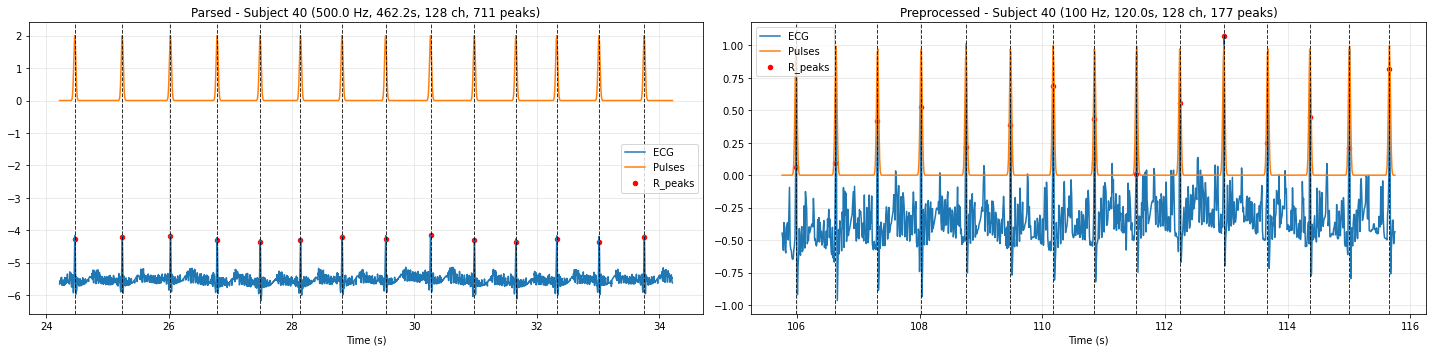

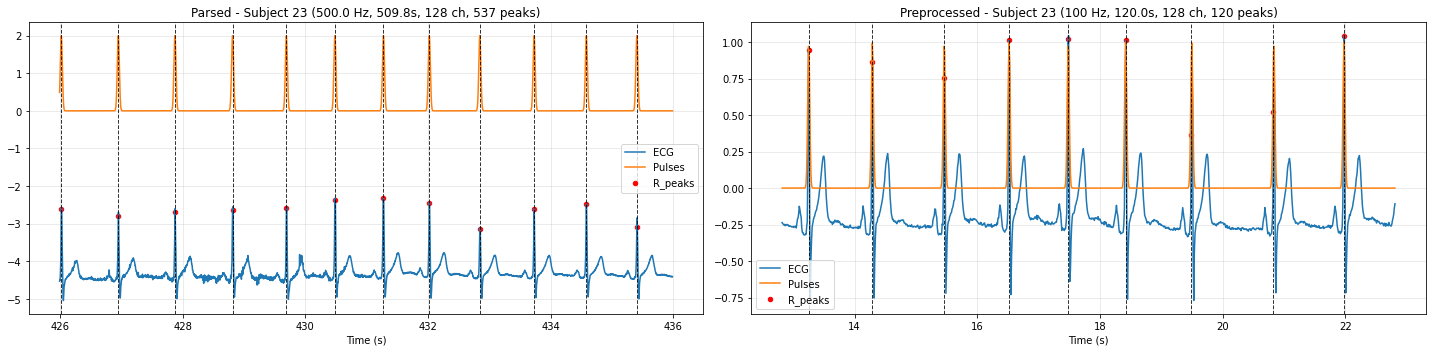

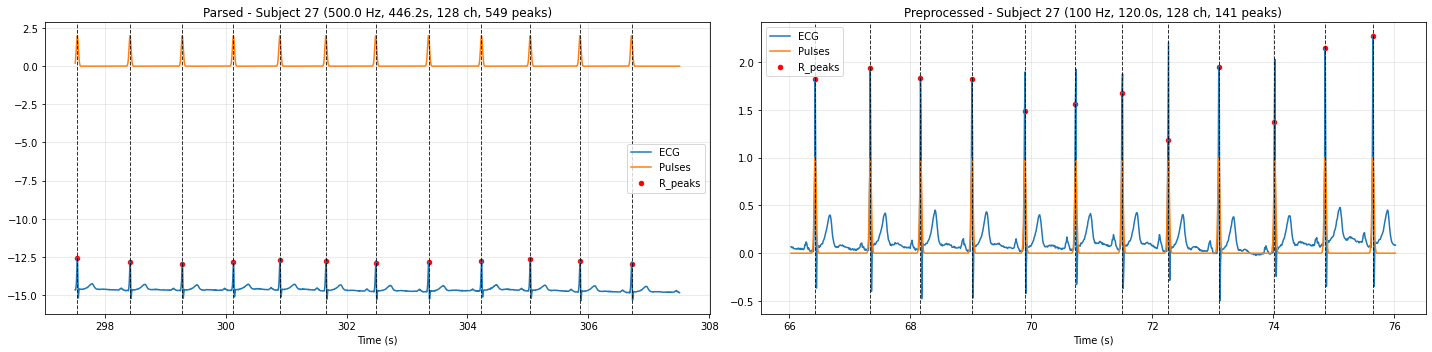

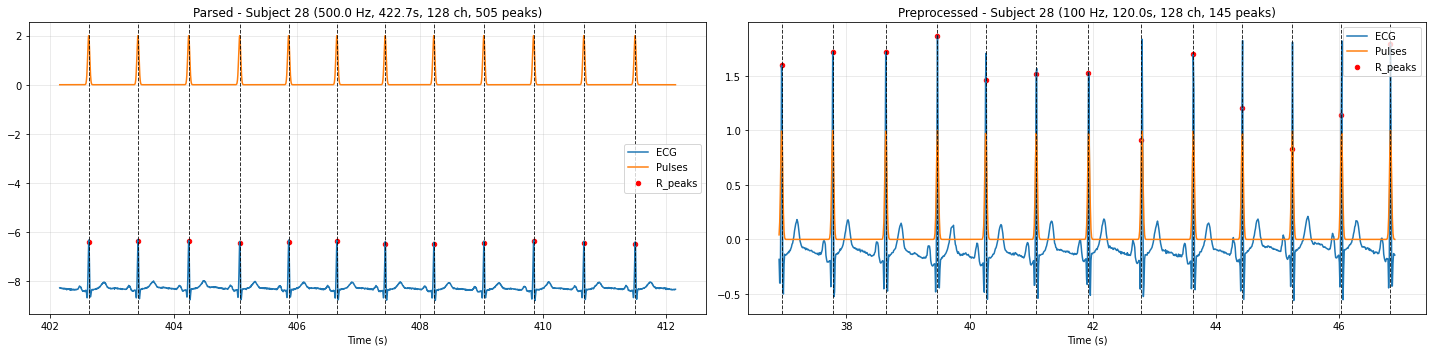

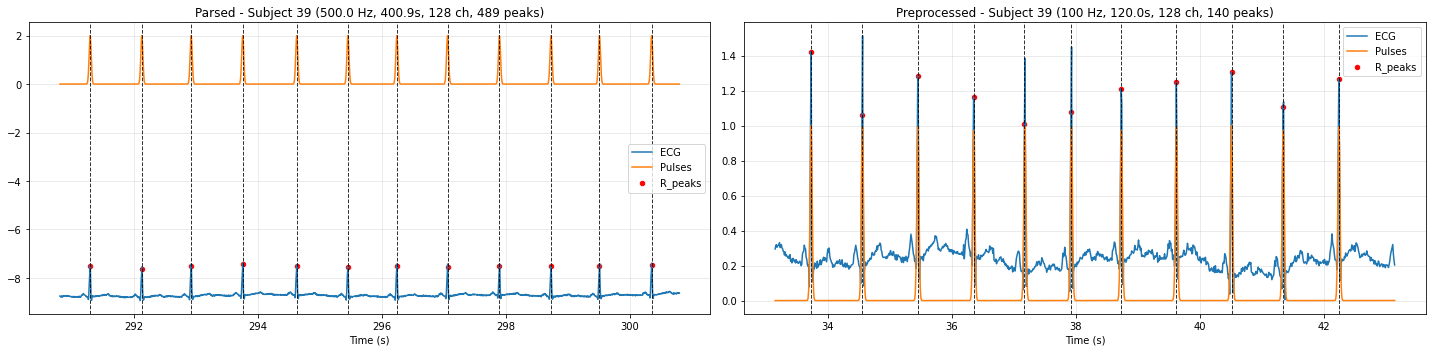

In [13]:
def load_subject_data(subj_id, A, width, impulse):
    """Load and parse data for a single subject."""
    # Load preprocessed EEG
    data = loadmat(f'Signals/P0{subj_id:02d}_prepro.mat')
    EEG_prepro = data['EEG_prepro']
    Y_prepro = EEG_prepro['data'][0, 0].astype(float)
    freq_prepro = float(EEG_prepro['srate'][0, 0])

    # Load ECG
    ecg_data = loadmat(f'Signals/P0{subj_id:02d}.mat')
    t_prepro = ecg_data["t_int"].flatten()
    t_prepro = np.insert(t_prepro, 0, 0.0)

    R_peak = ecg_data['R_peak'].flatten() - 1
    ECG = ecg_data['ECG_i'].flatten()
    ECG = np.insert(ECG, len(ECG), ECG[-1])

    # Generate pulse train
    ECG_pulse = train_pulse(Y_prepro, R_peak, A, width, freq_prepro, impulse)

    return { 'ECG': ECG, 'ECG_pulse': ECG_pulse, 'R_peaks': R_peak, 'EEG': Y_prepro, 'time': t_prepro, 'freq': freq_prepro }


def bandpass_eeg(x, fs, lowcut=0.1, highcut=22.5, order=4):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sosfiltfilt(sos, x, axis=-1)


def preprocess_subject_data(subject_data, tau):
    """Normalize and downsample subject data."""
    ECG = subject_data['ECG'].copy() - np.mean(subject_data['ECG'])
    ECG = ECG[::tau]  # downsample

    ECG_pulse = minmax_scale(subject_data['ECG_pulse'].copy().reshape(1, -1), feature_range=(0, 1), axis=1).flatten()
    ECG_pulse = ECG_pulse[::tau]

    EEG = minmax_scale(subject_data['EEG'].copy(), feature_range=(0, 1), axis=1)
    EEG = EEG - np.mean(EEG, axis=1, keepdims=True)  # Subtract per channel mean

    # Compute downsampled frequency
    freq = int(subject_data['freq'] / tau)

    # Downsample EEG
    EEG = EEG[:, ::tau]

    R_peaks = subject_data['R_peaks'].copy() // tau
    time = subject_data['time'].copy()[::tau]

    return {
        'ECG': ECG,
        'ECG_pulse': ECG_pulse,
        'R_peaks': R_peaks,
        'EEG': EEG,
        'time': time,
        'freq': freq
    }

# Load parsed data
if os.path.exists(parsed_path) and os.path.exists(preproc_path):
    with open(parsed_path, "rb") as f:
        data_parsed = pickle.load(f)
    with open(preproc_path, "rb") as f:
        data_preprocessed = pickle.load(f)
    print(f"Loaded parsed and preprocess data from cache")
else:
    print("Loading and parsing raw data...")
    data_parsed = {}
    data_preprocessed = {}
    for ss in subj_all:
        print(f"  Loading subject {ss}...")
        data_parsed[ss] = load_subject_data(ss, A, width, impulse)
        data_preprocessed[ss] = preprocess_subject_data(data_parsed[ss], tau)
    with open(parsed_path, "wb") as f:
        pickle.dump(data_parsed, f)
    print(f"Saved to {parsed_path}")
    with open(preproc_path, "wb") as f:
        pickle.dump(data_preprocessed, f)
    print(f"Saved to {preproc_path}")

# Apply HR band-pass AFTER loading (works with PKL cache)
if use_hr_band_filter:
    for ss in subj_all:
        fs_ds = int(data_preprocessed[ss]['freq'])
        eeg_unfilt = np.asarray(data_preprocessed[ss]['EEG'], dtype=float)
        data_preprocessed[ss]['EEG_unfilt'] = eeg_unfilt
        data_preprocessed[ss]['EEG'] = bandpass_eeg(eeg_unfilt, fs_ds, lowcut=lowcut, highcut=highcut)

# Trim all signals to the first dataset_max_seconds seconds
if dataset_max_seconds is not None:
    for ss in subj_all:
        fs_ds = int(data_preprocessed[ss]['freq'])
        max_samples = int(dataset_max_seconds * fs_ds)
        # Bound against available length
        T = data_preprocessed[ss]['EEG'].shape[1]
        max_samples = min(max_samples, T)

        # Slice time-series
        data_preprocessed[ss]['EEG'] = data_preprocessed[ss]['EEG'][:, :max_samples]
        if 'EEG_unfilt' in data_preprocessed[ss]:
            data_preprocessed[ss]['EEG_unfilt'] = data_preprocessed[ss]['EEG_unfilt'][:, :max_samples]
        data_preprocessed[ss]['ECG'] = data_preprocessed[ss]['ECG'][:max_samples]
        data_preprocessed[ss]['ECG_pulse'] = data_preprocessed[ss]['ECG_pulse'][:max_samples]
        data_preprocessed[ss]['time'] = data_preprocessed[ss]['time'][:max_samples]

        # Keep R-peaks within the window
        rps = np.asarray(data_preprocessed[ss]['R_peaks'])
        data_preprocessed[ss]['R_peaks'] = rps[rps < max_samples]

# Visualize parsed data
for ss in subj_all:
    visualize_ecg_and_peaks(ss, data_parsed[ss], data_preprocessed[ss], duration_sec)

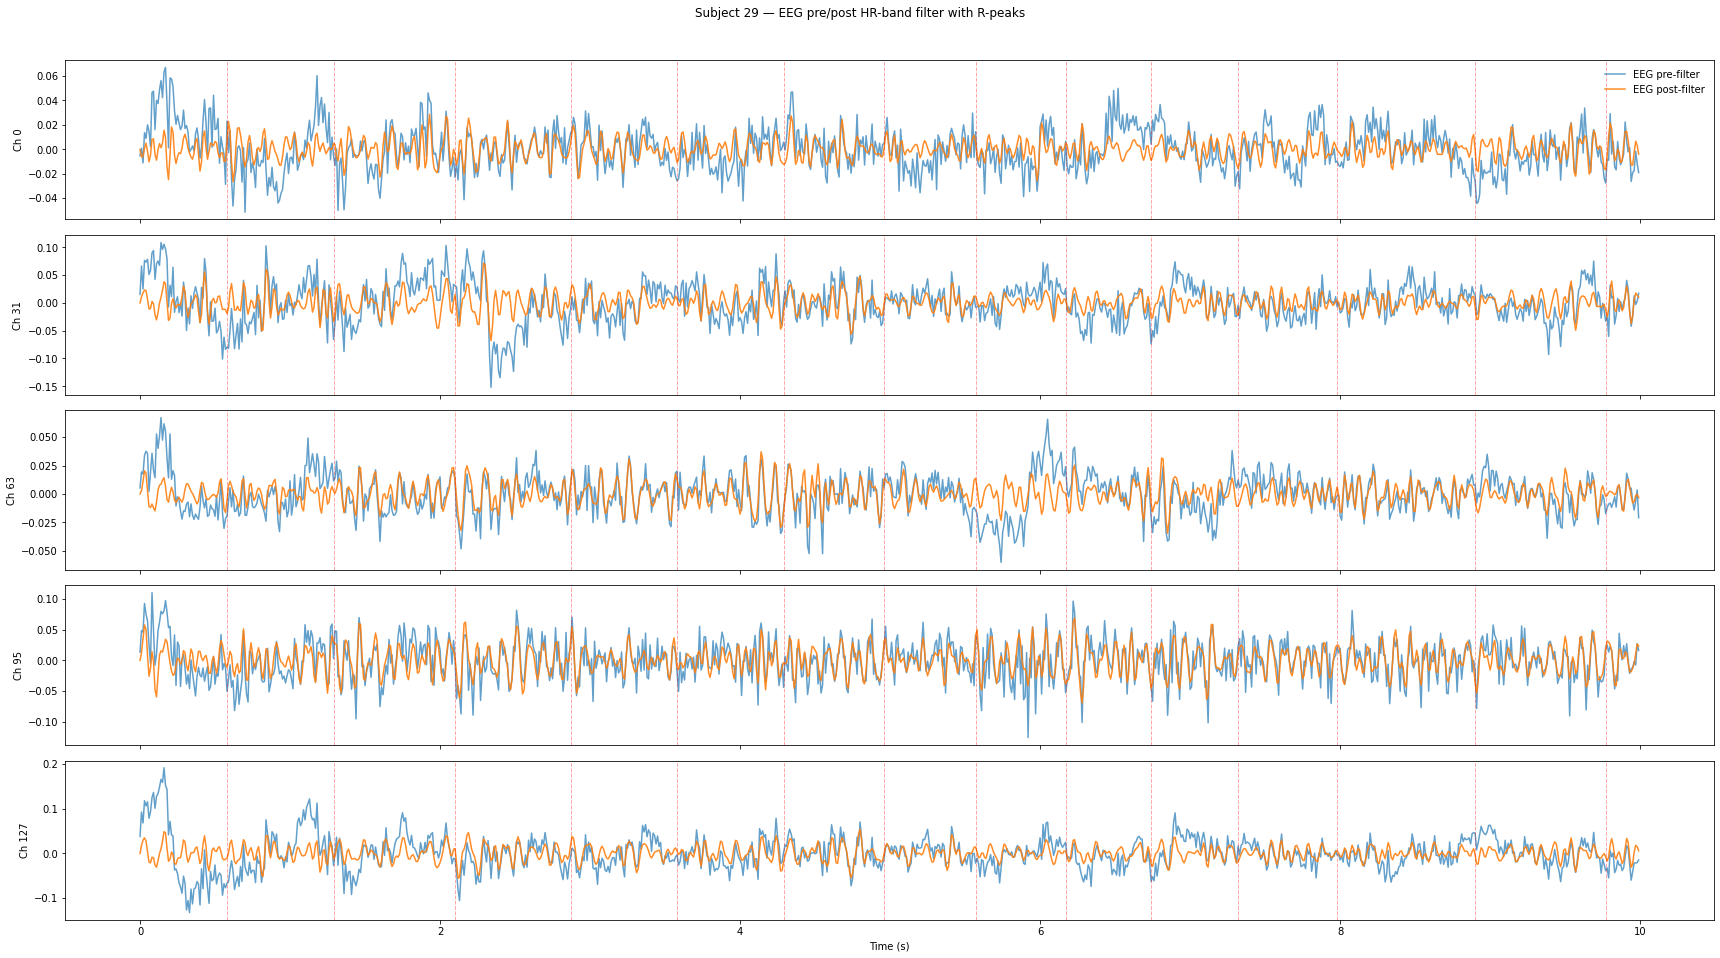

In [14]:
# EEG pre/post-filter visualization with R-peaks (5 channels) + residual and metrics
plot_subj = test_subj  # subject to visualize

pre_ds = data_preprocessed[plot_subj].get('EEG_unfilt', None)
post_ds = data_preprocessed[plot_subj]['EEG']
fs_ds = data_preprocessed[plot_subj]['freq']
rpeaks_ds = data_preprocessed[plot_subj]['R_peaks']

# Reconstruct pre-filter downsampled EEG if not present in cache
if pre_ds is None:
    raw = data_parsed[plot_subj]['EEG'].copy()  # (C, T_full)
    raw = minmax_scale(raw, feature_range=(0, 1), axis=1)
    raw = raw - np.mean(raw, axis=1, keepdims=True)
    pre_ds = raw[:, ::tau]

n_channels = pre_ds.shape[0]
n_samp = min(int(duration_sec * fs_ds), pre_ds.shape[1])  # plot up to duration_sec
t = np.arange(pre_ds.shape[1]) / fs_ds

# Select 5 channels evenly across the montage
n_plot = 5
chan_idx = np.linspace(0, n_channels - 1, n_plot, dtype=int)
fig, axes = plt.subplots(n_plot, 1, figsize=(24, 2.6 * n_plot), sharex=True)

for i, ch in enumerate(chan_idx):
    ax = axes[i]
    y0 = pre_ds[ch, :n_samp]
    y1 = post_ds[ch, :n_samp]

    ax.plot(t[:n_samp], y0, label='EEG pre-filter', color='C0', alpha=0.7)
    ax.plot(t[:n_samp], y1, label='EEG post-filter', color='C1', alpha=0.9)

    # R-peak vertical lines (downsampled indices)
    for rp in rpeaks_ds:
        if 0 <= rp < n_samp:
            ax.axvline(t[rp], color='r', linestyle='--', alpha=0.35, linewidth=1)
    ax.set_ylabel(f"Ch {ch}")
    if i == 0:
        ax.legend(loc='upper right', frameon=False)

axes[-1].set_xlabel('Time (s)')
fig.suptitle(f'Subject {plot_subj} — EEG pre/post HR-band filter with R-peaks', y=1.02)
plt.tight_layout()
plt.show()

Computing EEG channel zero-lag correlations with ECG_pulse (aggregate)...
Subject 29: Top 10 channels (zero-lag abs corr)
   1. Ch 34 | corr=+0.1519
   2. Ch 107 | corr=-0.0468
   3. Ch 43 | corr=-0.0379
   4. Ch 12 | corr=-0.0307
   5. Ch 08 | corr=-0.0284
   6. Ch 13 | corr=-0.0246
   7. Ch 102 | corr=-0.0215
   8. Ch 116 | corr=-0.0209
   9. Ch 97 | corr=-0.0209
  10. Ch 119 | corr=-0.0206
Subject 41: Top 10 channels (zero-lag abs corr)
   1. Ch 43 | corr=+0.0417
   2. Ch 73 | corr=+0.0407
   3. Ch 63 | corr=+0.0406
   4. Ch 55 | corr=+0.0400
   5. Ch 68 | corr=+0.0386
   6. Ch 74 | corr=+0.0383
   7. Ch 62 | corr=+0.0378
   8. Ch 93 | corr=+0.0363
   9. Ch 56 | corr=+0.0363
  10. Ch 53 | corr=+0.0356
Subject 30: Top 10 channels (zero-lag abs corr)
   1. Ch 48 | corr=-0.0285
   2. Ch 44 | corr=-0.0274
   3. Ch 43 | corr=-0.0273
   4. Ch 72 | corr=-0.0266
   5. Ch 127 | corr=-0.0266
   6. Ch 92 | corr=+0.0213
   7. Ch 100 | corr=+0.0199
   8. Ch 38 | corr=-0.0191
   9. Ch 99 | corr=+

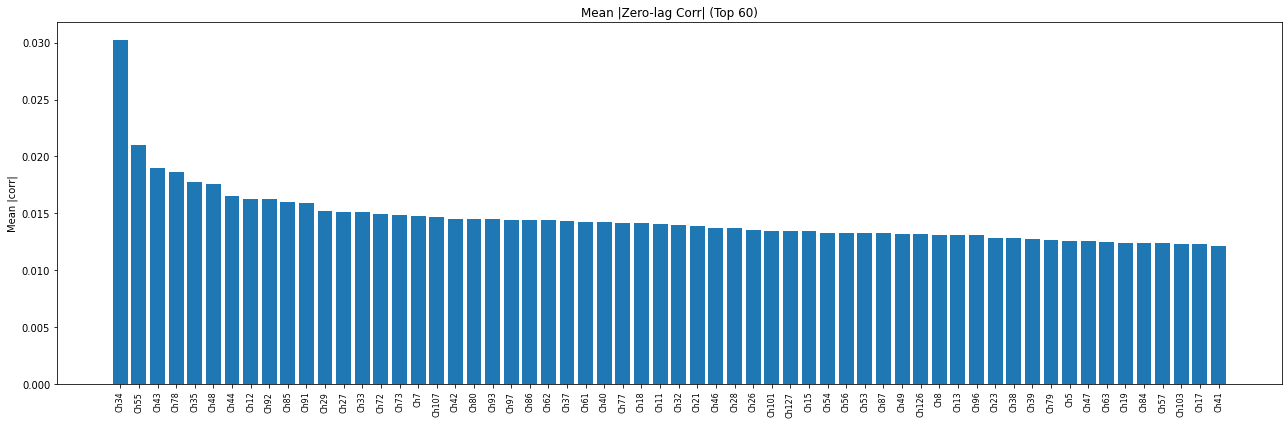

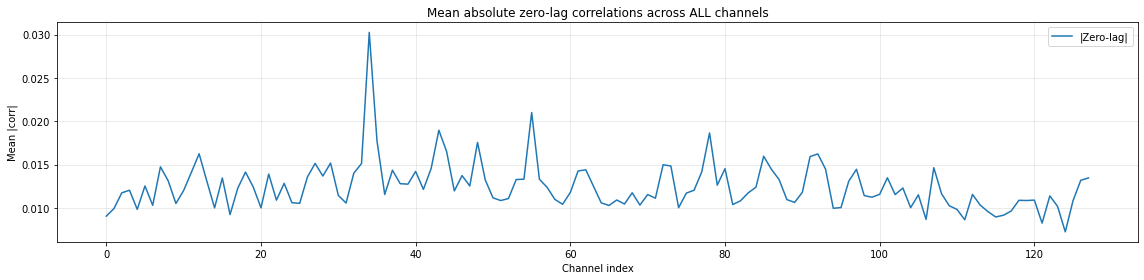

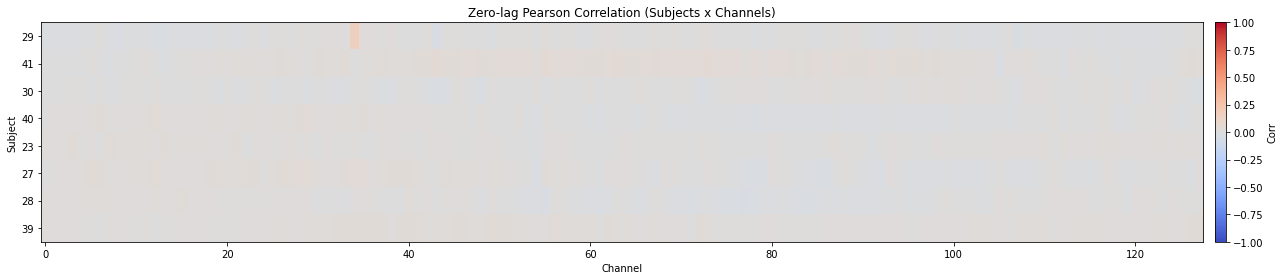


Unified per-feature analysis for test subject 29

Feature set: EEG_zero_lag
   1. Ch 34 | corr=+0.1519
   2. Ch 107 | corr=-0.0468
   3. Ch 43 | corr=-0.0379
   4. Ch 12 | corr=-0.0307
   5. Ch 08 | corr=-0.0284


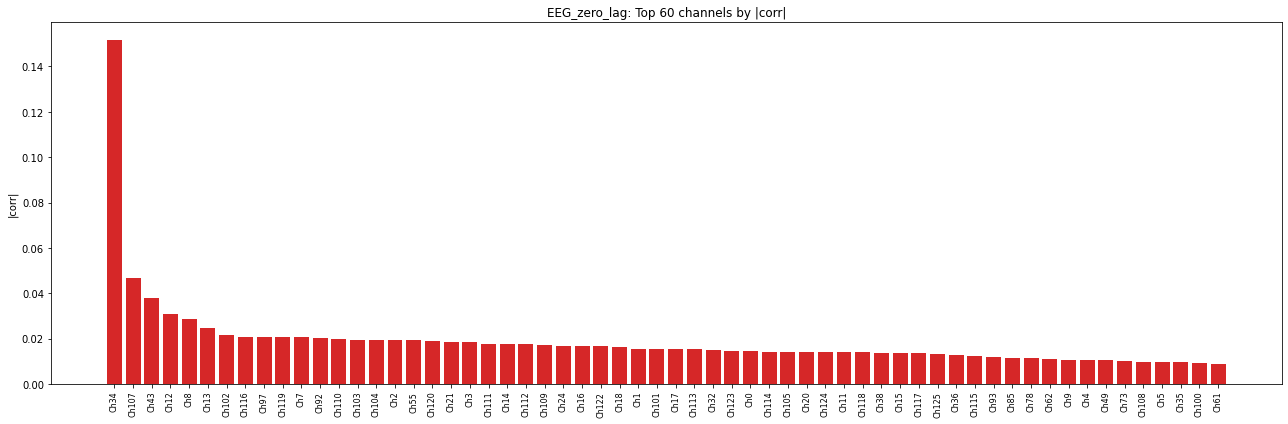

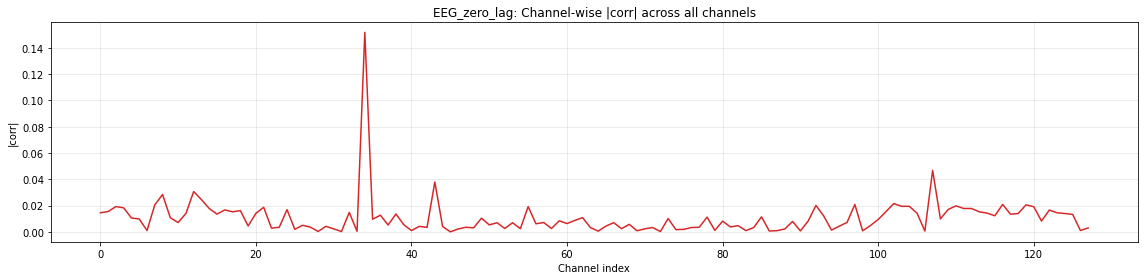

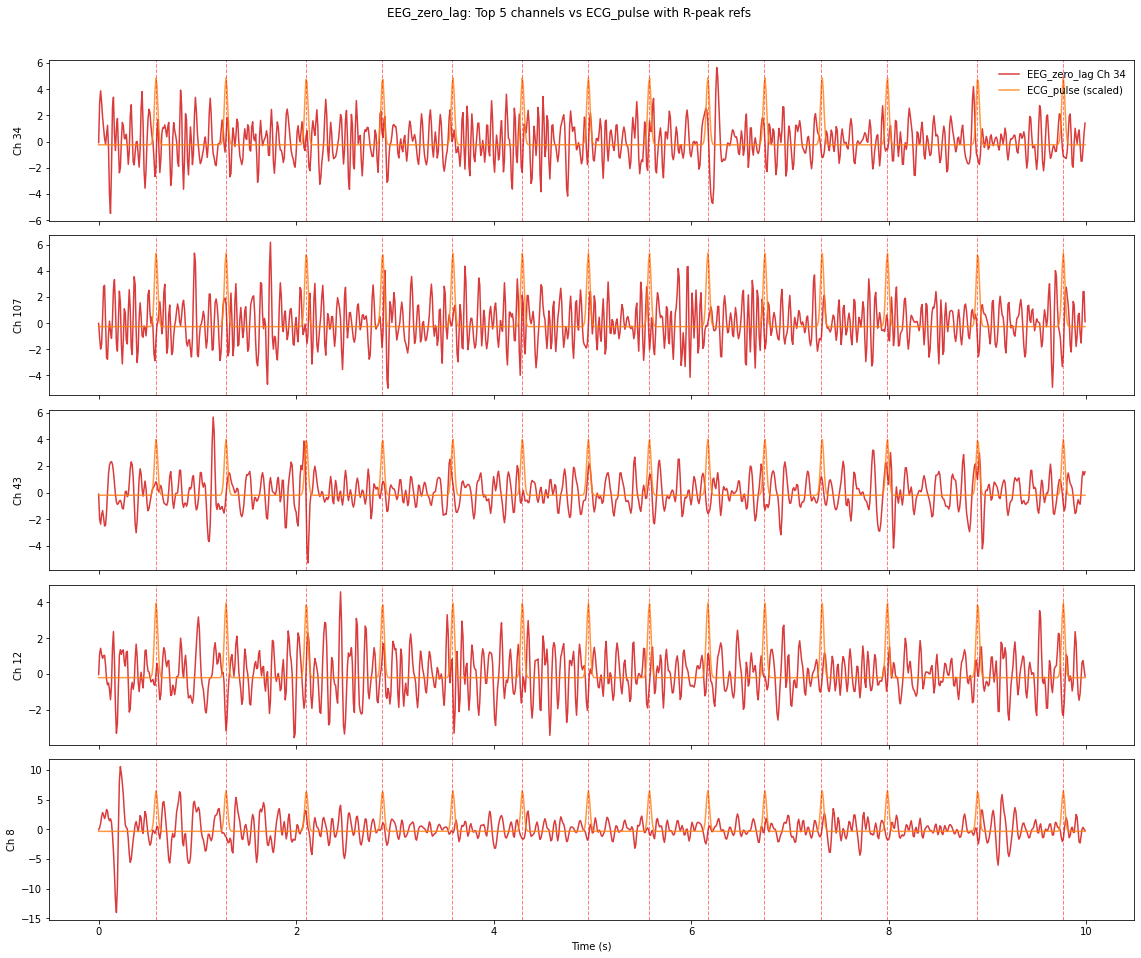


Feature set: Energy(squared, smooth=0.15s)
   1. Ch 34 | corr=+0.1362
   2. Ch 39 | corr=+0.0575
   3. Ch 95 | corr=+0.0526
   4. Ch 99 | corr=+0.0518
   5. Ch 89 | corr=+0.0483


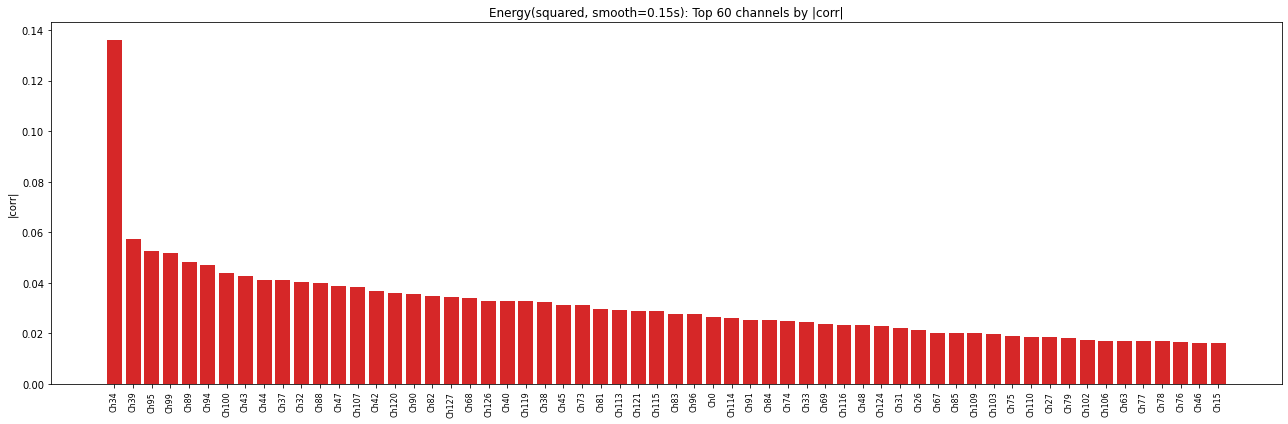

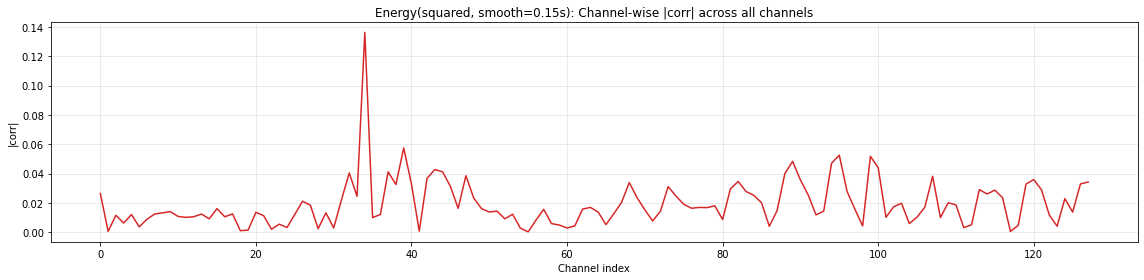

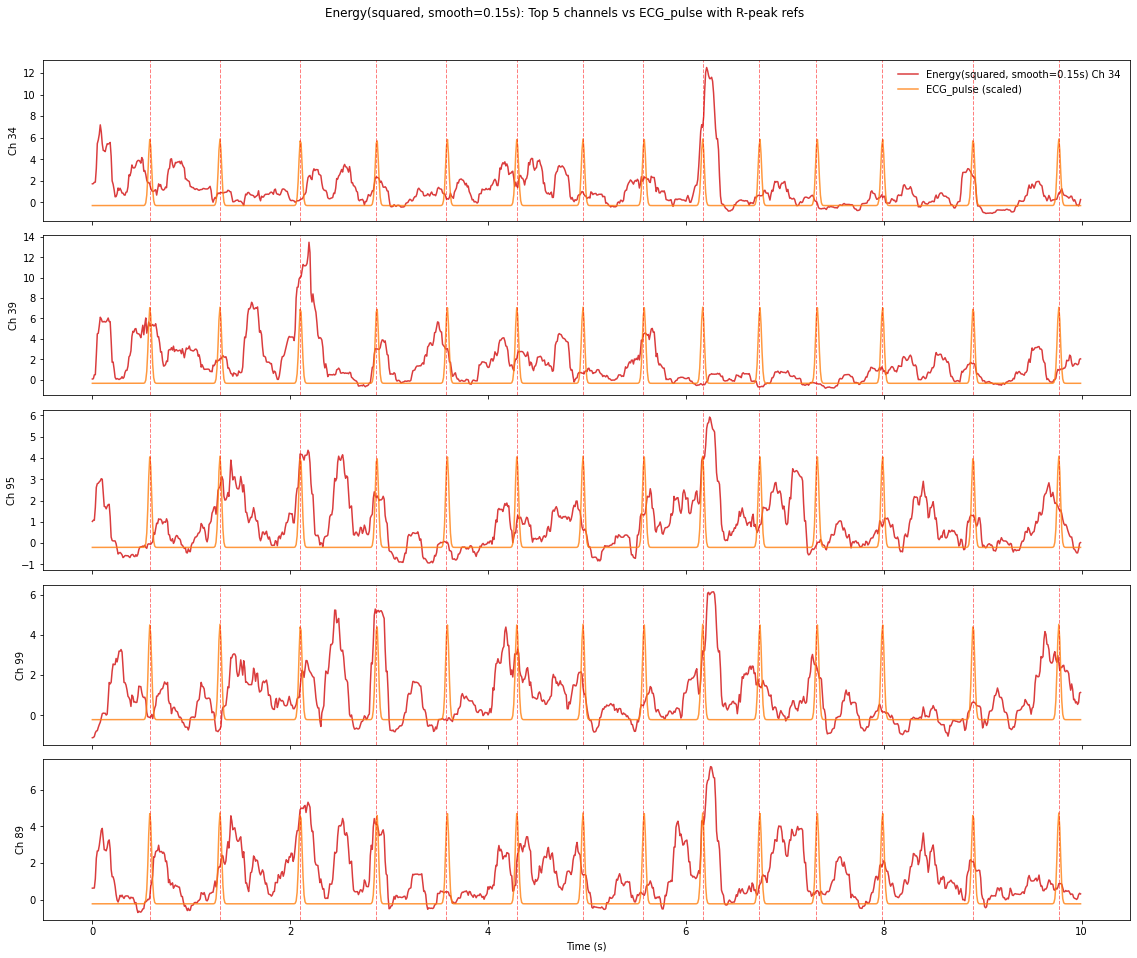


Feature set: Op:hilbert_env
   1. Ch 34 | corr=+0.1563
   2. Ch 43 | corr=+0.0584
   3. Ch 99 | corr=+0.0532
   4. Ch 95 | corr=+0.0500
   5. Ch 107 | corr=+0.0481


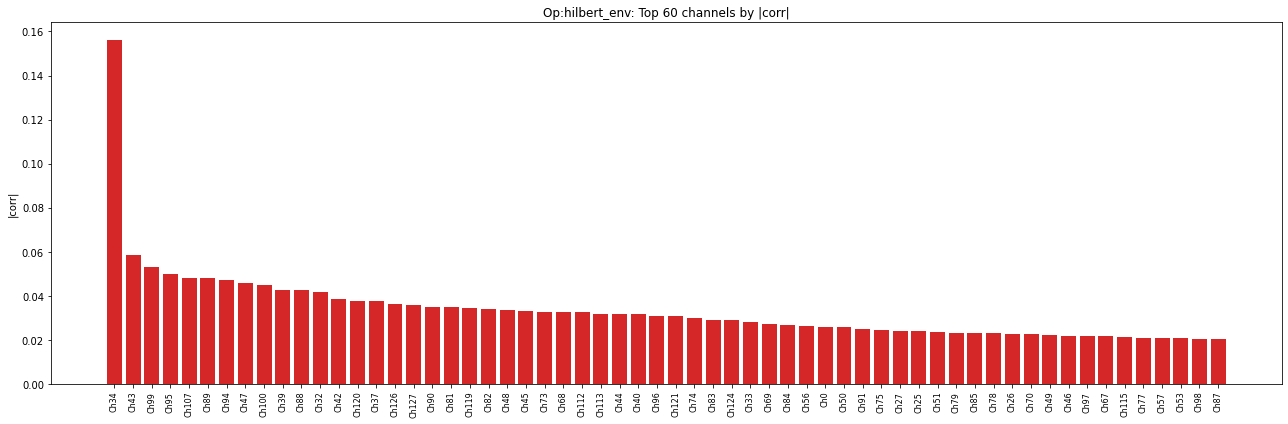

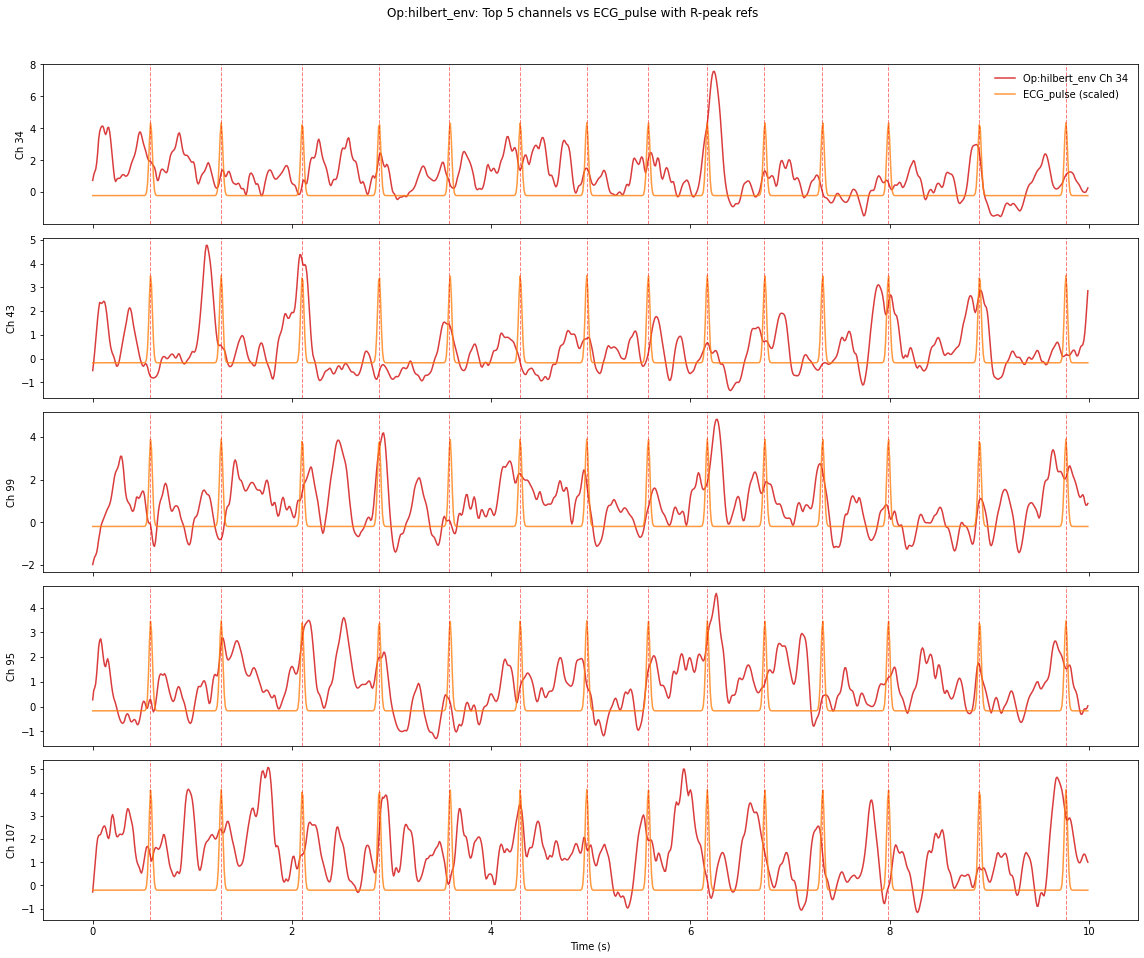


Feature set: Op:shannon
   1. Ch 34 | corr=+0.1397
   2. Ch 99 | corr=+0.0541
   3. Ch 95 | corr=+0.0535
   4. Ch 39 | corr=+0.0526
   5. Ch 89 | corr=+0.0496


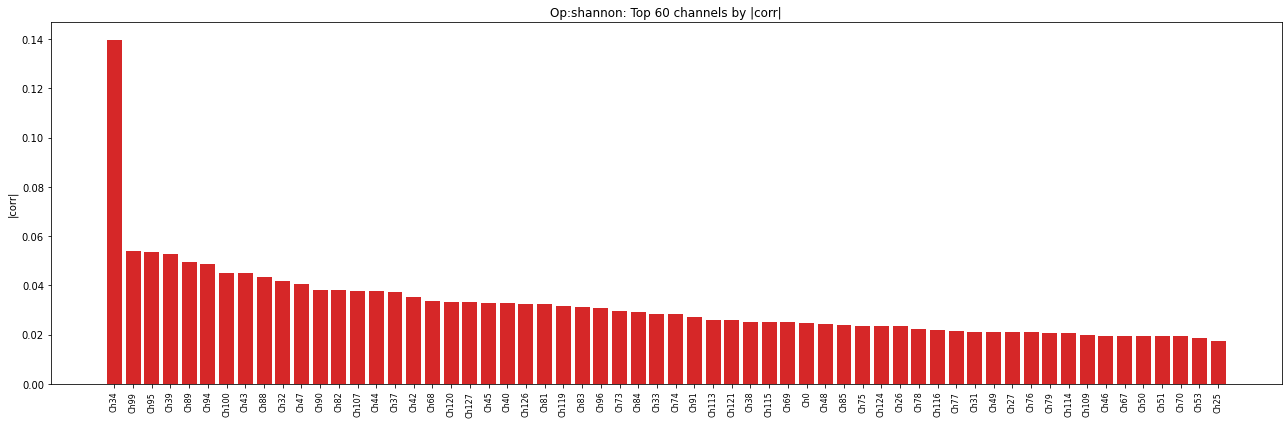

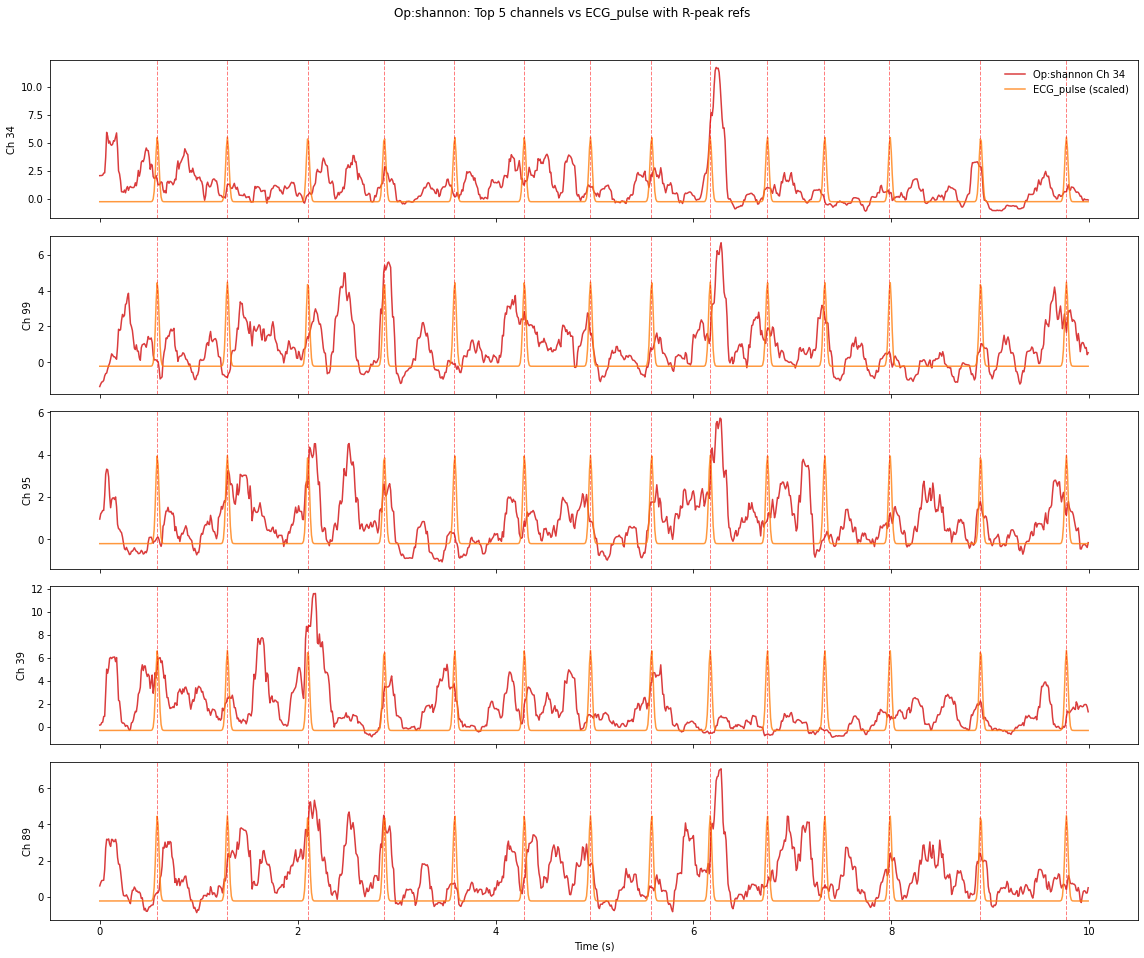


Feature set: Op:ssf
   1. Ch 34 | corr=+0.0711
   2. Ch 43 | corr=+0.0583
   3. Ch 99 | corr=+0.0550
   4. Ch 94 | corr=+0.0517
   5. Ch 95 | corr=+0.0456


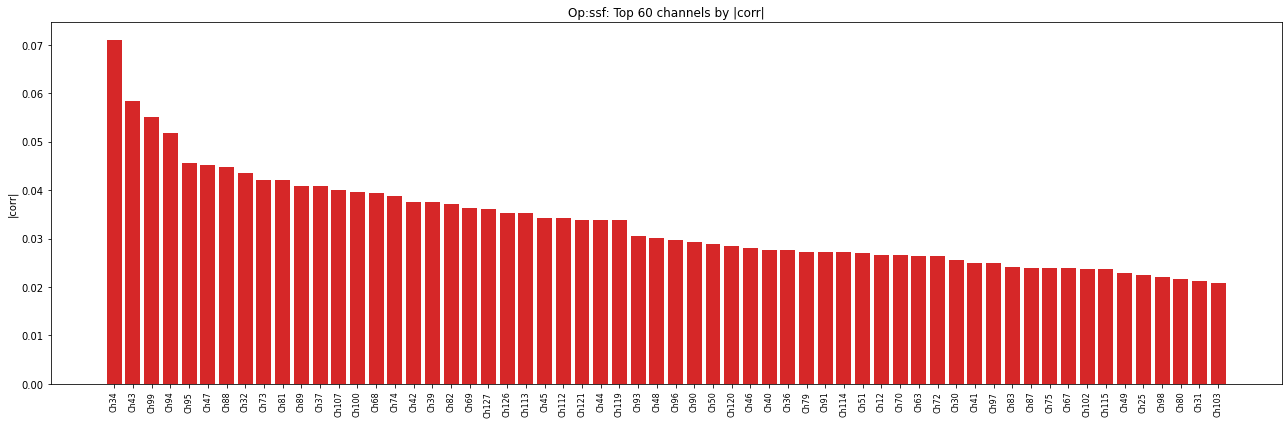

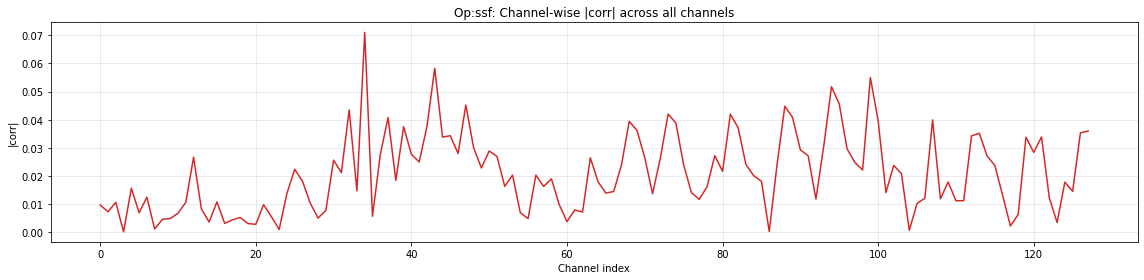

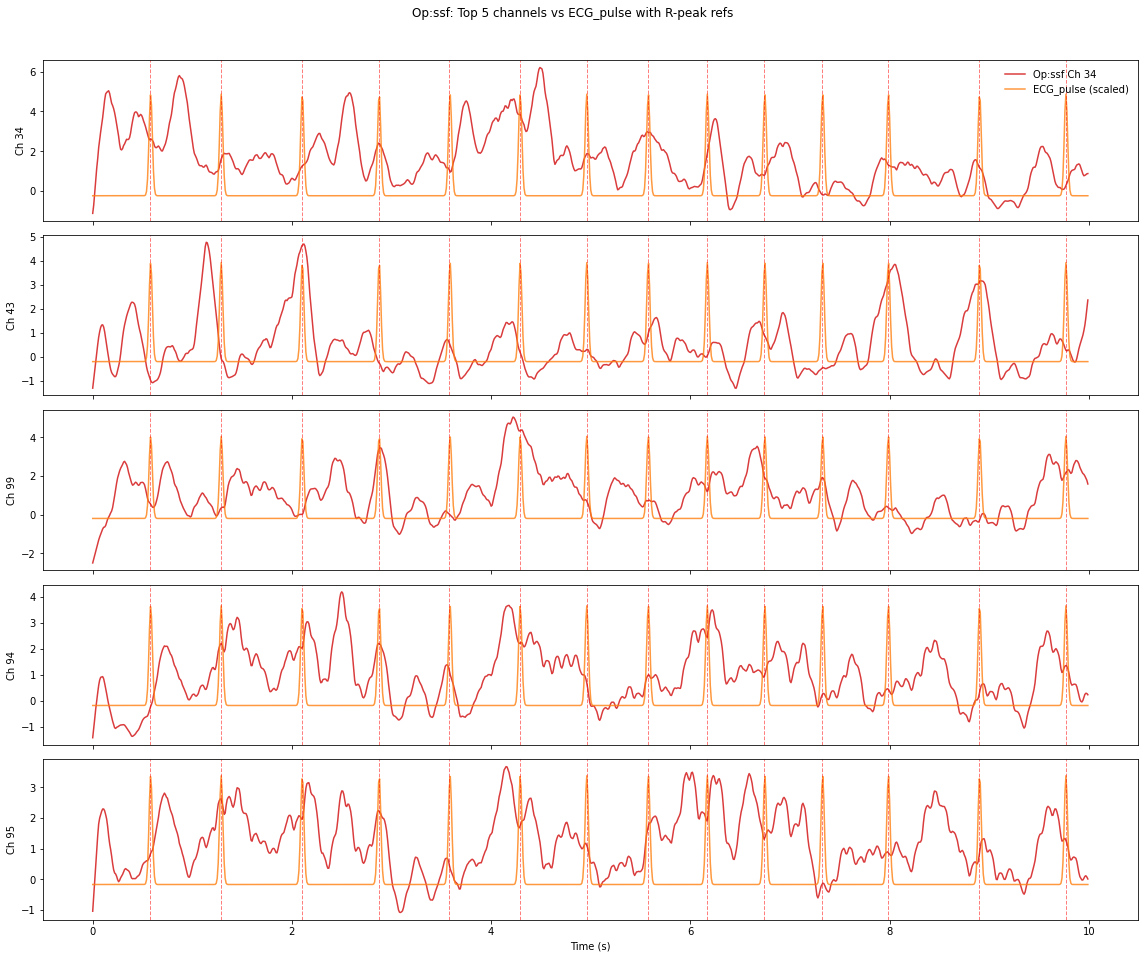


Feature set: Op:mwi
   1. Ch 34 | corr=+0.0601
   2. Ch 43 | corr=+0.0587
   3. Ch 39 | corr=+0.0494
   4. Ch 94 | corr=+0.0487
   5. Ch 99 | corr=+0.0480


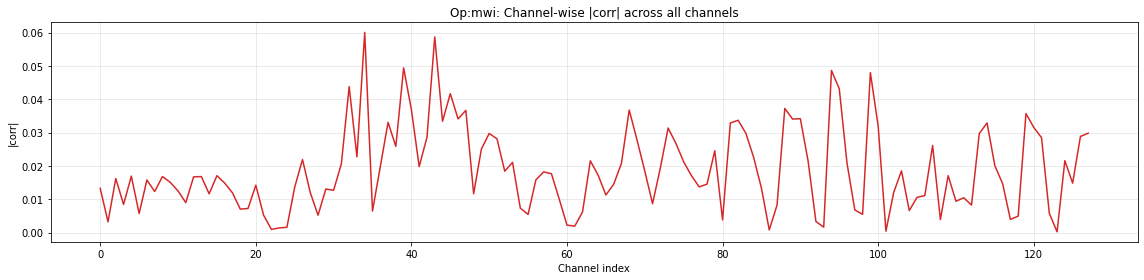

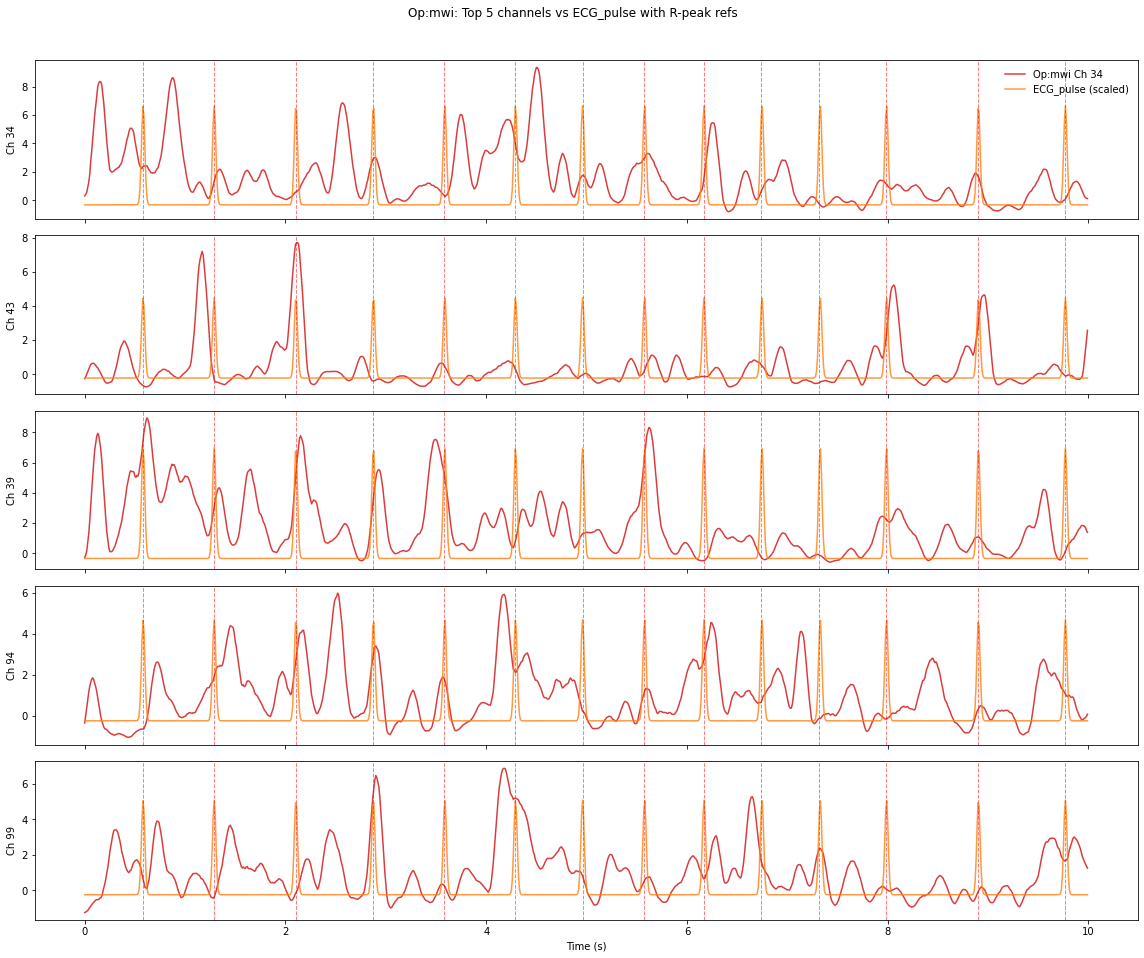


Feature set: Op:tkeo
   1. Ch 34 | corr=+0.0681
   2. Ch 39 | corr=+0.0564
   3. Ch 43 | corr=+0.0542
   4. Ch 99 | corr=+0.0447
   5. Ch 45 | corr=+0.0436


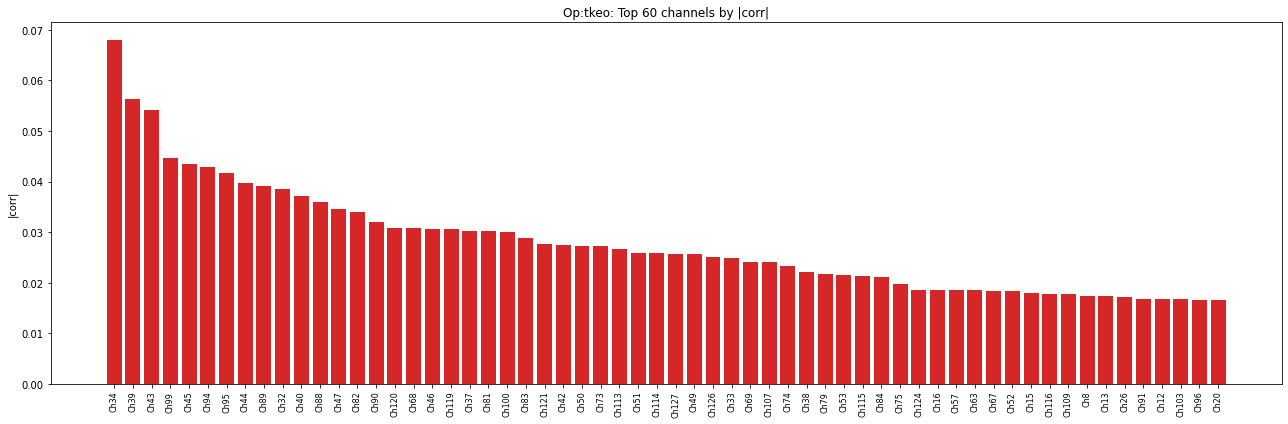

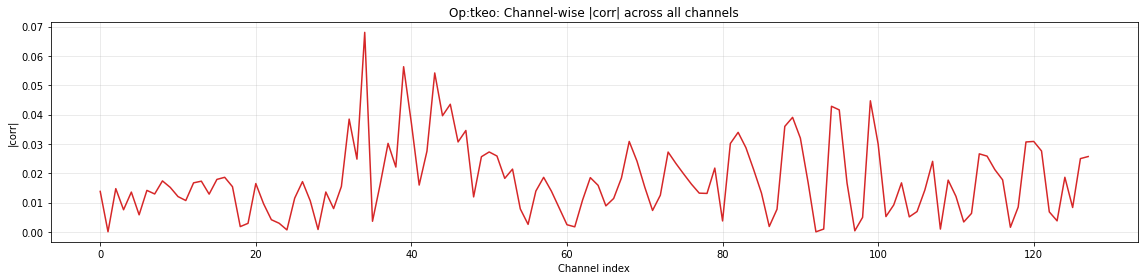

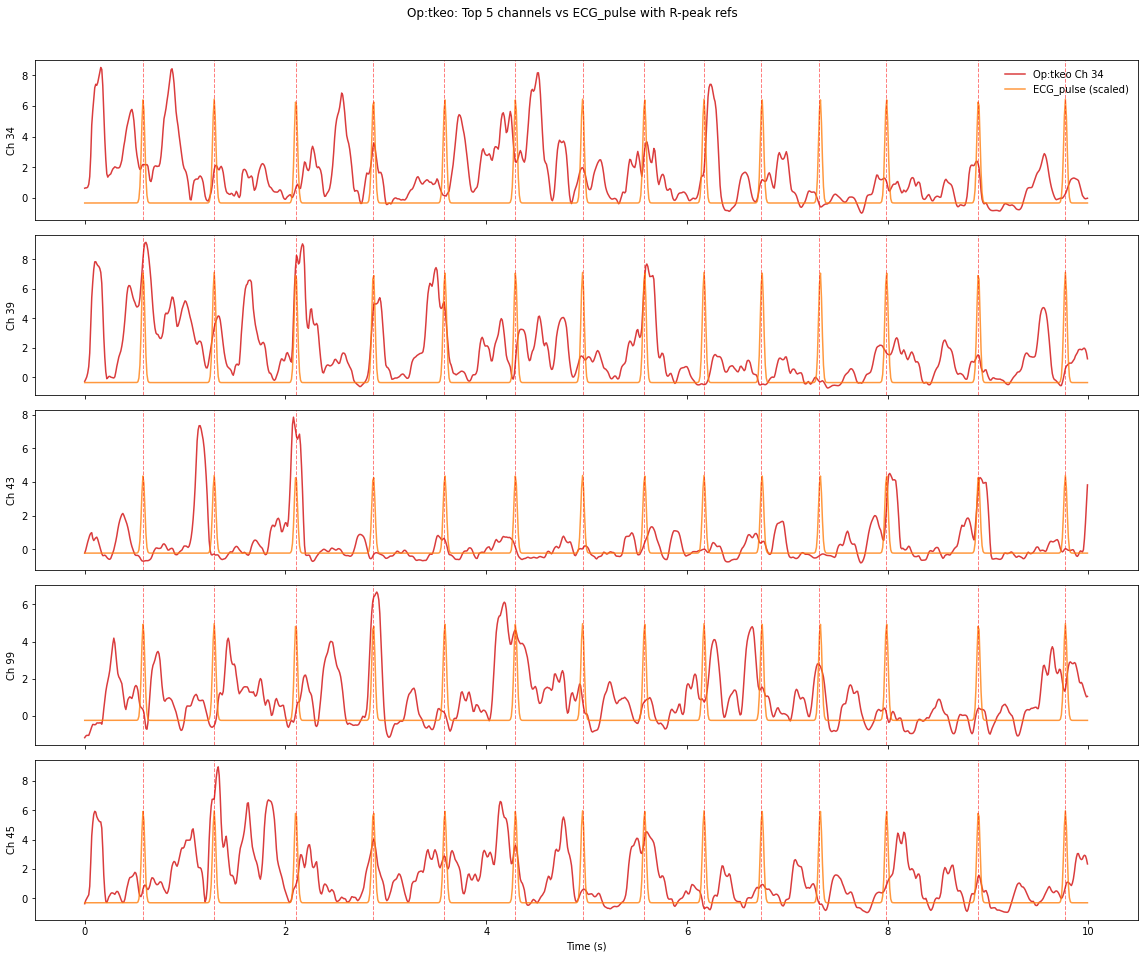


Feature set: Op:squared
   1. Ch 34 | corr=+0.1352
   2. Ch 39 | corr=+0.0558
   3. Ch 95 | corr=+0.0537
   4. Ch 99 | corr=+0.0535
   5. Ch 89 | corr=+0.0499


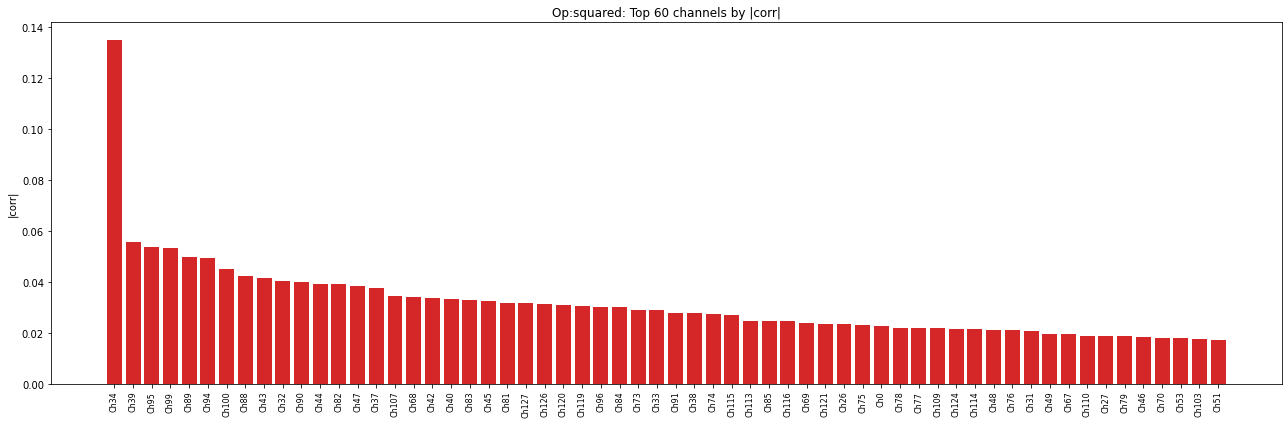

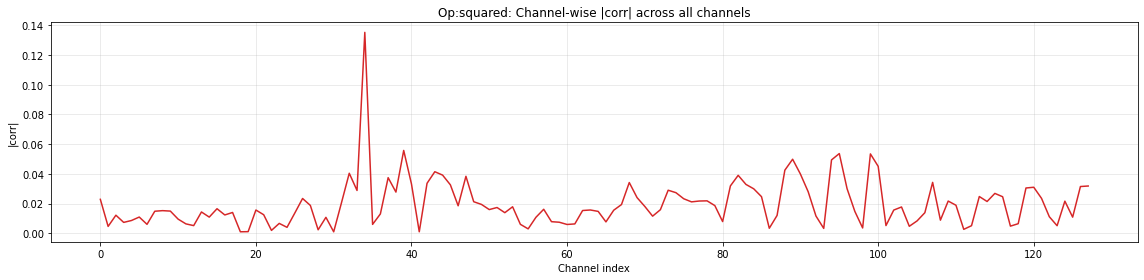

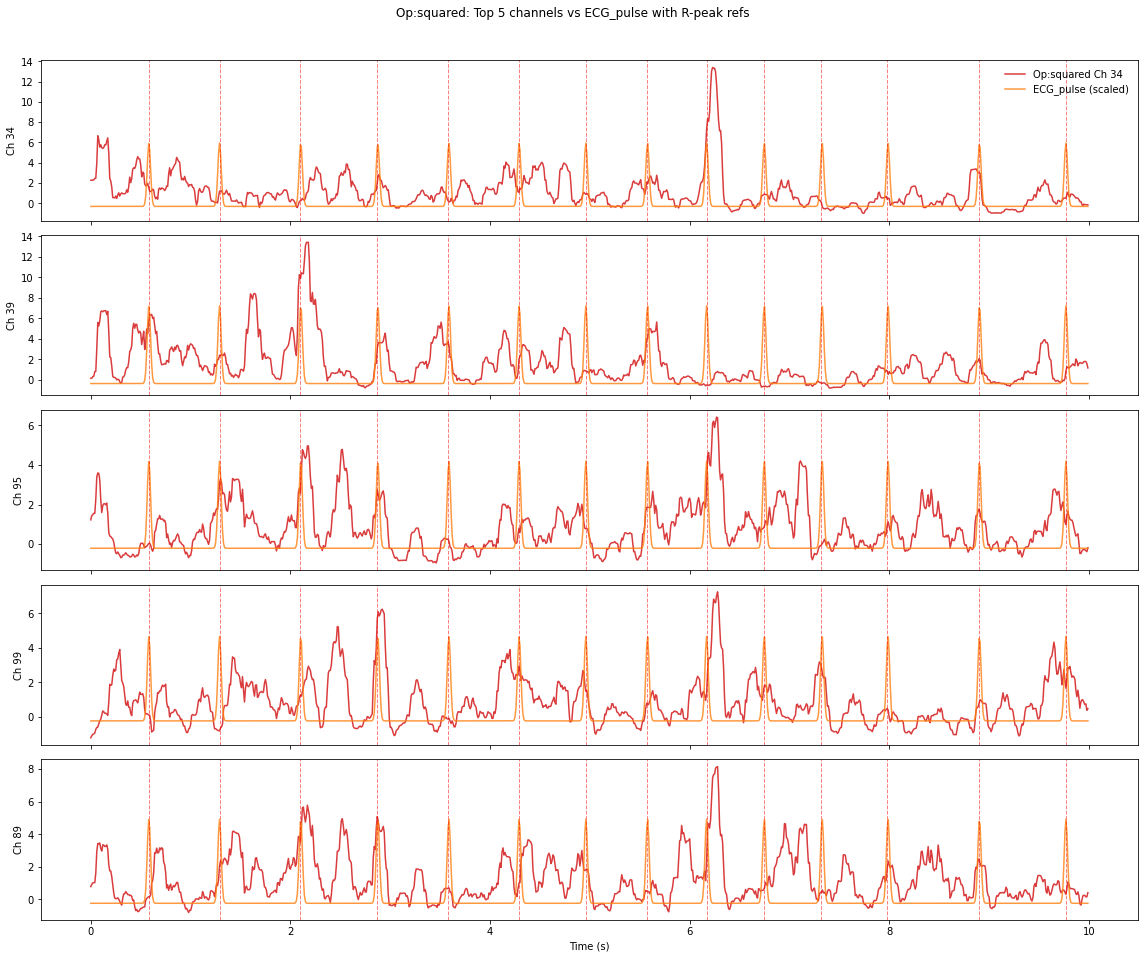

In [15]:
# Unified channel feature correlation analysis (zero-lag EEG, energy, multi-operators)
import numpy as np, matplotlib.pyplot as plt
from scipy.signal import hilbert

# Parameters (tunable)
top_k_print = 10          # printed ranking per feature set
top_k_plot_bars = 60      # bar chart channels
top_k_timeplot = 5        # time-series channels

energy_method = 'squared'       # 'squared' or 'tkeo'
energy_smooth_win_s = 0.15

ops_to_eval = ['hilbert_env', 'shannon', 'ssf', 'mwi', 'tkeo', 'squared']
op_smooth_win_s = 0.12
ssf_win_s = 0.15
mwi_win_s = 0.08

subj_to_plot = test_subj
fs_ds = int(data_preprocessed[subj_to_plot]['freq'])
EEG_subj = data_preprocessed[subj_to_plot]['EEG']            # (C,T)
pulse_subj = data_preprocessed[subj_to_plot]['ECG_pulse']    # (T,)
rpeaks_subj = np.asarray(data_preprocessed[subj_to_plot]['R_peaks'], dtype=int)

C_subj, T_subj = EEG_subj.shape
L_subj = min(T_subj, pulse_subj.shape[0])
EEG_subj = EEG_subj[:, :L_subj]; pulse_subj = pulse_subj[:L_subj]
pulse_z_subj = (pulse_subj - pulse_subj.mean()) / (pulse_subj.std() + 1e-8)

def zscore_channels(X):
    return (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

def moving_avg(x, w):
    if w <= 1: return x
    return np.convolve(x, np.ones(w)/w, mode='same')

# Feature builders
def feat_eeg_zero(subj_id):
    return data_preprocessed[subj_id]['EEG']

def feat_energy(x, fs, method='squared', smooth_win_s=0.15):
    w = max(1, int(round(smooth_win_s * fs)))
    C, T = x.shape
    out = np.zeros_like(x)
    for ch in range(C):
        sig = x[ch]
        if method == 'tkeo':
            if sig.size < 3:
                e = sig*sig
            else:
                e = np.empty_like(sig); e[0]=sig[0]**2; e[-1]=sig[-1]**2; e[1:-1]=sig[1:-1]**2 - sig[:-2]*sig[2:]; e = np.maximum(e,0)
        else:
            e = sig*sig
        out[ch] = moving_avg(e, w)
    return out

def op_squared(x): return x*x
def op_tkeo(x):
    if x.size < 3: return x*x
    y = np.empty_like(x); y[0]=x[0]**2; y[-1]=x[-1]**2; y[1:-1]=x[1:-1]**2 - x[:-2]*x[2:]; return np.maximum(y,0)
def op_hilbert_env(x): return np.abs(hilbert(x))
def op_shannon(x, eps=1e-8):
    e = x*x; return -e * np.log(e + eps)
def op_ssf(x, win):
    d = np.diff(x, prepend=x[0]); d_pos = np.maximum(d,0); return moving_avg(d_pos, win)
def op_mwi(x, win):
    d = np.diff(x, prepend=x[0]); y = d*d; return moving_avg(y, win)

def build_operator_features(EEG, fs):
    w_smooth = max(1, int(round(op_smooth_win_s * fs)))
    w_ssf = max(1, int(round(ssf_win_s * fs)))
    w_mwi = max(1, int(round(mwi_win_s * fs)))
    op_funcs = {
        'squared': lambda x: op_squared(x),
        'tkeo': lambda x: op_tkeo(x),
        'hilbert_env': lambda x: op_hilbert_env(x),
        'shannon': lambda x: op_shannon(x),
        'ssf': lambda x: op_ssf(x, w_ssf),
        'mwi': lambda x: op_mwi(x, w_mwi)
    }
    feats = {}
    C, T = EEG.shape
    for name in ops_to_eval:
        arr = np.zeros((C, T), dtype=float)
        f = op_funcs[name]
        for ch in range(C):
            y = f(EEG[ch])
            # light smoothing post-op
            arr[ch] = moving_avg(y, w_smooth)
        feats[name] = arr
    return feats

def channel_corr(feat_z, pulse_z):
    C = feat_z.shape[0]
    corr = np.empty(C, dtype=float)
    for ch in range(C):
        corr[ch] = np.corrcoef(feat_z[ch], pulse_z)[0,1]
    return corr

def plot_corr_suite(name, feat_z, corr, pulse_z, rpeaks, fs, duration_sec, top_bars=60, top_time=5):
    corr_abs = np.abs(corr)
    order = np.argsort(-corr_abs)
    top_bars_idx = order[:min(top_bars, corr_abs.size)]
    top_time_idx = order[:min(top_time, corr_abs.size)]
    print(f"\nFeature set: {name}")
    for i, ch in enumerate(top_time_idx,1):
        print(f"  {i:2d}. Ch {ch:02d} | corr={corr[ch]:+.4f}")
    # Bar chart
    fig, ax = plt.subplots(figsize=(18,6))
    ax.bar([f"Ch{c}" for c in top_bars_idx], corr_abs[top_bars_idx], color='C3')
    ax.set_title(f"{name}: Top {top_bars_idx.size} channels by |corr|")
    ax.set_ylabel('|corr|'); ax.tick_params(axis='x', rotation=90, labelsize=8)
    plt.tight_layout(); plt.show()
    # Line plot
    fig, ax = plt.subplots(figsize=(16,4))
    ax.plot(range(corr_abs.size), corr_abs, color='C3')
    ax.set_title(f"{name}: Channel-wise |corr| across all channels")
    ax.set_xlabel('Channel index'); ax.set_ylabel('|corr|'); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
    # Time plots
    n_samp = min(int(duration_sec * fs), feat_z.shape[1])
    t = np.arange(n_samp) / fs
    fig, axes = plt.subplots(len(top_time_idx), 1, figsize=(16, 2.6*len(top_time_idx)), sharex=True)
    if len(top_time_idx) == 1: axes = [axes]
    for i, ch in enumerate(top_time_idx):
        ax = axes[i]; y_ch = feat_z[ch, :n_samp]; p = pulse_z[:n_samp]
        scale = np.std(y_ch)/(np.std(p)+1e-8)*0.7
        ax.plot(t, y_ch, label=f'{name} Ch {ch}', color='C3', alpha=0.9)
        ax.plot(t, p*scale, label='ECG_pulse (scaled)', color='C1', alpha=0.8)
        mask = (rpeaks >=0) & (rpeaks < n_samp)
        for rp in rpeaks[mask]: ax.axvline(t[rp], color='r', linestyle='--', alpha=0.5, linewidth=1)
        ax.set_ylabel(f"Ch {ch}")
        if i==0: ax.legend(loc='upper right', frameon=False)
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(f"{name}: Top {len(top_time_idx)} channels vs ECG_pulse with R-peak refs", y=1.02)
    plt.tight_layout(); plt.show()

# 1) Aggregate zero-lag EEG correlation across subjects (unchanged logic, unified)
print("Computing EEG channel zero-lag correlations with ECG_pulse (aggregate)...")
subject_zero = {}
for ss in subj_all:
    EEG_ss = data_preprocessed[ss]['EEG']
    pulse_ss = data_preprocessed[ss]['ECG_pulse']
    L = min(EEG_ss.shape[1], pulse_ss.shape[0])
    X = EEG_ss[:, :L]; y = pulse_ss[:L]
    y_z = (y - y.mean())/(y.std()+1e-8)
    X_z = zscore_channels(X)
    corr = channel_corr(X_z, y_z)
    subject_zero[ss] = corr
    idx_sorted = np.argsort(-np.abs(corr))[:top_k_print]
    print(f"Subject {ss}: Top {top_k_print} channels (zero-lag abs corr)")
    for rank, ch in enumerate(idx_sorted,1):
        print(f"  {rank:2d}. Ch {ch:02d} | corr={corr[ch]:+.4f}")

all_zero = np.stack([subject_zero[ss] for ss in subj_all], axis=0)
mean_abs_zero = np.mean(np.abs(all_zero), axis=0)
C_all = mean_abs_zero.size
top_idx_zero = np.argsort(-mean_abs_zero)[:min(top_k_plot_bars, C_all)]
print("\nAggregate top channels by mean |zero-lag corr|:")
for rank, ch in enumerate(top_idx_zero[:min(10, top_idx_zero.size)],1):
    print(f"  {rank:2d}. Ch {ch:02d} | mean|zero|={mean_abs_zero[ch]:.4f}")

fig, ax = plt.subplots(figsize=(18,6))
ax.bar([f"Ch{c}" for c in top_idx_zero], mean_abs_zero[top_idx_zero], color='C0')
ax.set_title(f'Mean |Zero-lag Corr| (Top {top_idx_zero.size})'); ax.set_ylabel('Mean |corr|')
ax.tick_params(axis='x', rotation=90, labelsize=8); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(range(C_all), mean_abs_zero, label='|Zero-lag|', color='C0')
ax.set_title('Mean absolute zero-lag correlations across ALL channels'); ax.set_xlabel('Channel index'); ax.set_ylabel('Mean |corr|')
ax.grid(True, alpha=0.3); ax.legend(); plt.tight_layout(); plt.show()

try:
    fig, ax = plt.subplots(figsize=(18,4))
    im = ax.imshow(all_zero, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title('Zero-lag Pearson Correlation (Subjects x Channels)'); ax.set_ylabel('Subject'); ax.set_xlabel('Channel')
    ax.set_yticks(range(len(subj_all))); ax.set_yticklabels(subj_all)
    cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.01); cbar.set_label('Corr')
    plt.tight_layout(); plt.show()
except Exception as e:
    print(f"Heatmap skipped: {e}")

# Per-feature analyses for test subject
print("\nUnified per-feature analysis for test subject", subj_to_plot)

# a) EEG zero-lag (subject-level) using test subject only now for suite plots
EEG_zero_feat = EEG_subj
EEG_zero_z = zscore_channels(EEG_zero_feat)
corr_zero = channel_corr(EEG_zero_z, pulse_z_subj)
plot_corr_suite('EEG_zero_lag', EEG_zero_z, corr_zero, pulse_z_subj, rpeaks_subj, fs_ds, duration_sec, top_bars=top_k_plot_bars, top_time=top_k_timeplot)

# b) Instantaneous energy
energy_feat = feat_energy(EEG_subj, fs_ds, method=energy_method, smooth_win_s=energy_smooth_win_s)
energy_z = zscore_channels(energy_feat)
corr_energy = channel_corr(energy_z, pulse_z_subj)
plot_corr_suite(f'Energy({energy_method}, smooth={energy_smooth_win_s}s)', energy_z, corr_energy, pulse_z_subj, rpeaks_subj, fs_ds, duration_sec, top_bars=top_k_plot_bars, top_time=top_k_timeplot)

# c) Multi-operators
op_feats = build_operator_features(EEG_subj, fs_ds)
for name, arr in op_feats.items():
    feat_z = zscore_channels(arr)
    corr_op = channel_corr(feat_z, pulse_z_subj)
    plot_corr_suite(f'Op:{name}', feat_z, corr_op, pulse_z_subj, rpeaks_subj, fs_ds, duration_sec, top_bars=top_k_plot_bars, top_time=top_k_timeplot)